In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
#from tqdm.notebook import tqdm
#import seaborn as sns
import pandas as pd
from numpy import exp, sqrt, pi

# Recovering Prior Knowledge with Maximum Likelihood Estimation

Here is a demo code on how to recover prior knowledge with MLE. First, we need some "ground truth" data; in this case, we will use Ally's data, which is saved in a CSV file called `cleandata_MLE`.

In [2]:
data = pd.read_csv("cleandata_MLE.csv")
data

,userId,lessonId,start,legit,id,screen_name,email,factId,image_file_id,answer,...,given_response,alternatives,model_parameters,sessionId,factText,repetition,textbox_text.text,prior_knowledge,flags_click.time,date
0,89506,Asian Flags,1697760711487,True,38038585,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,0,nepal,-1,8.3122,2023-10-19_17h04.11.738
1,89506,Asian Flags,1697760711487,True,38038622,user170,user170@research.com,337299,26386,india,...,India,NaN,"{""id"":8",NaN,337299,0,india,1,18.2194,2023-10-19_17h04.11.738
2,89506,Asian Flags,1697760711487,True,38038540,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,1,nepal,-1,8.3122,2023-10-19_17h04.11.738
3,89506,Asian Flags,1697760711487,True,38038541,user170,user170@research.com,337299,26386,india,...,India,NaN,"{""id"":8",NaN,337299,1,india,1,18.2194,2023-10-19_17h04.11.738
4,89506,Asian Flags,1697760711487,True,38038623,user170,user170@research.com,337310,26355,vietnam,...,Vietnam,NaN,"{""id"":8",NaN,337310,0,mongolia,-1,18.3841,2023-10-19_17h04.11.738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15506,94540,Caribbean Flags,1699069924067,True,38863156,user85,user85@research.com,337633,26366,martinique,...,Martinique,NaN,"{""id"":8",NaN,337633,9,NaN,-1,1.4394,2023-11-03_20h38.38.427
15507,94540,Caribbean Flags,1699069924067,True,38863233,user85,user85@research.com,337625,26358,bahamas,...,Bahamas,NaN,"{""id"":8",NaN,337625,9,NaN,-1,1.4821,2023-11-03_20h38.38.427
15508,94540,Caribbean Flags,1699069924067,True,38863178,user85,user85@research.com,337636,26369,st lucia,...,St Lucia,NaN,"{""id"":8",NaN,337636,11,NaN,-1,1.1807,2023-11-03_20h38.38.427
15509,94540,Caribbean Flags,1699069924067,True,38863157,user85,user85@research.com,337625,26358,bahamas,...,Bahamas,NaN,"{""id"":8",NaN,337625,10,NaN,-1,1.4821,2023-11-03_20h38.38.427


We are going to focus on one particular participant, 89506, and one lesson only, Asian Flags. So we are going to isolate this set of facts into a subset of data called `sdata`.

In [3]:
sdata = data[data.userId == 89506]
sdata = sdata.reset_index(drop=True)
sdata = sdata[sdata.lessonId == "Asian Flags"]

Let's see how many facts we have -- it should be about 15

In [4]:
len(set(sdata.factId))

15

# Model

To do MLE, we need a model that predicts the probability of observing a specific response and response times for every fact that is presented during a session. We will also need to include some constraints on the parameters of the mode.

First, we need to estimate the time that has passed from the first time they have seen the flag (in Qualtrics) and the first time they answer. We need to because Qualtrics is the equivalent of a "study" trial.

Some parameters are kept constant at the group level

In [5]:
RT = -0.8   # Retrieval threshold
TER = 0.3   # time for encoding and responding
F = 1.0     # Latency factor
C = 0.25    # Spacing weight
S = 0.25    # Noise

Now, let's define our model. Our model is given by two equations that determine the activation of a memory given a value of $\alpha$ and the times at which the traces $t_1, t_2, \dots, t_N$ have been created:

$A(m,t) = \sum_i (t- t_i)^{-d(i)}$

$d(i) = c \times e^{A(m,t)} + \alpha$

In [6]:
def calculate_activation(time, traces, alpha, c=C):
    traces = [x for x in traces if x < time]
    d = alpha
    memory_odds = 0
    for trace in traces:
        trace_odds = (time - trace) ** -d
        memory_odds += trace_odds
        d = c * np.exp(np.log(memory_odds)) + alpha
    return np.log(memory_odds)

Now, we can define our likelihood functions. The two likelihood functions will give us the two probability density functions for responses and response times, given some individual parameters (activation, threshold, noise, TER, and F).

In [7]:
def resp_prob(observed, activation, threshold, noise):
    prob = 1 / (1 + np.exp(-(activation - threshold)/noise))
    if observed == 0:
        return 1 - prob
    else:
        return prob


def rt_prob(observed, activation, threshold, noise, f, ter):    
    alpha = exp(-activation) * f
    beta = sqrt(3)/(pi*noise)
    t = observed - ter
    p =  ((beta/alpha) * (t/alpha)**(beta -1)) / (1 + (t/alpha)**beta)**2
    if p is np.nan or p is np.inf:
        return 0
    else:
        return p
    

And now, let's look at the examples of two PDFs

[0.06496916912866402, 0.935030830871336]


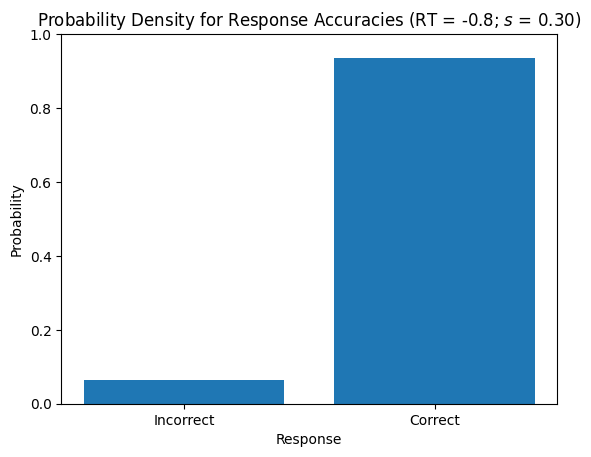

/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/1426252809.py:13: RuntimeWarning: invalid value encountered in power
  p =  ((beta/alpha) * (t/alpha)**(beta -1)) / (1 + (t/alpha)**beta)**2


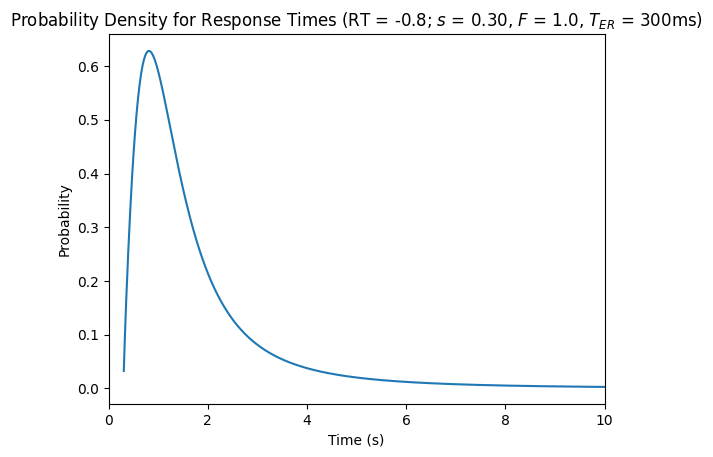

In [8]:
accuracies = np.array((0, 1))
p = [resp_prob(x, 0, -0.8, 0.3) for x in accuracies]
print(p)
plt.bar(["Incorrect", "Correct"], p)
plt.title("Probability Density for Response Accuracies (RT = %.1f; $s$ = %.2f)" % (-0.8, 0.3))
plt.xlabel("Response")
plt.ylim((0,1))
plt.ylabel("Probability")
plt.show()


t = np.linspace(0.1, 10, 1000)
prt = rt_prob(t, activation=0, threshold=-0.8, noise=0.3, f=1, ter=0.3)
plt.plot(t, prt)
plt.title("Probability Density for Response Times (RT = %.1f; $s$ = %.2f, $F$ = %.1f, $T_{ER}$ = %dms)" % (-0.8, 0.3, 1.0, 300))
plt.xlabel("Time (s)")
plt.ylabel("Probability")
plt.xlim((0, 10))
plt.show()

# Applying MLE 

Here is a walk-thorugh of how MLE works. We start with the Asian Flags data for our test subject, saved in `sdata`. Of this data, we are going to focus only on the presentations pertaining a specific fact, and save this data in `sfdata`. 


In [9]:
sfdata = sdata[sdata.factId == 337301]
sfdata

#sdata means data for one subject
#sfdata means data for one fact for a particular subject

,userId,lessonId,start,legit,id,screen_name,email,factId,image_file_id,answer,...,given_response,alternatives,model_parameters,sessionId,factText,repetition,textbox_text.text,prior_knowledge,flags_click.time,date
0,89506,Asian Flags,1697760711487,True,38038585,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,0,nepal,-1,8.3122,2023-10-19_17h04.11.738
2,89506,Asian Flags,1697760711487,True,38038540,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,1,nepal,-1,8.3122,2023-10-19_17h04.11.738
13,89506,Asian Flags,1697760711487,True,38038590,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,2,nepal,-1,8.3122,2023-10-19_17h04.11.738
60,89506,Asian Flags,1697760711487,True,38038558,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,3,nepal,-1,8.3122,2023-10-19_17h04.11.738
100,89506,Asian Flags,1697760711487,True,38038717,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,4,nepal,-1,8.3122,2023-10-19_17h04.11.738


## Log-likelihood function

Now, we create a _log-likelihood_ function. The function loops for every presentation in `sfdata` (every presentation of a specific fact) and  calculates the probabilities of observing each of the corresponding responses and response times, given a specific set of parameter values. The probabilities are then log-transformed and summed.

In [10]:

def loglikelihood(data, offset, sof, rt, ter, f, noise, blc):
    """Log likelihood"""
    traces = [0.0001]
    start = list(set(data.start))[0]
    LL = 0.0
    for i in range(data.shape[0]):
        event = data.iloc[i, :]
        time = (event["presentationStartTime"] - start)/1000 + offset
        accuracy = event["correct"] 
        resp_time = event["reactionTime"] 
        # Expected activation
        activation = blc + calculate_activation(time, traces, sof)
        
        # Log-likelihoods
        LL += np.log(resp_prob(accuracy, activation, rt, noise))
        LL += np.log(rt_prob(resp_time, activation, rt, noise, f, ter))
                        
        # Add new encoding to traces
        traces.append(time)
    
    return LL     

For example, here is the log-likelihood of the observed results in `sfdata`:

In [11]:
offsets = pd.read_csv("offset.csv")


def get_offset(userId, lessonId, factId):
    offsets = pd.read_csv("offset.csv")
    myoffset = offsets[offsets.userId == 89506]
    myoffset = myoffset[offsets.lessonId == "Asian Flags"]
    myoffset = myoffset[offsets.factId == 337301]
    myoffset = myoffset.offset.iloc[0]
    return myoffset

myoffset = get_offset(89506, "Asian Flags", 337301)

offsets

/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/4191849141.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  myoffset = myoffset[offsets.lessonId == "Asian Flags"]
/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/4191849141.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  myoffset = myoffset[offsets.factId == 337301]


,userId,lessonId,screen_name,factId,answer,prior_knowledge,offset
0,89506,Asian Flags,user170,337301,maldives,no,25659.749
1,89506,Asian Flags,user170,337299,india,yes,25665.486
2,89506,Asian Flags,user170,337310,vietnam,no,25680.034
3,89506,Asian Flags,user170,337308,taiwan,no,25685.562
4,89506,Asian Flags,user170,337300,japan,yes,25704.591
...,...,...,...,...,...,...,...
2027,94540,Caribbean Flags,user85,337631,haiti,no,22531.325
2028,94540,Caribbean Flags,user85,337637,trinidad,no,22535.007
2029,94540,Caribbean Flags,user85,337635,st kitts and nevis,no,22544.503
2030,94540,Caribbean Flags,user85,337632,jamaica,yes,22548.941


In [12]:
unknown_sof = pd.read_csv("sofs.csv")
unknown_sof

,userId,lessonId,mean_alpha
0,89328,Asian Flags,0.294678
1,89328,Caribbean Flags,0.296016
2,89330,Caribbean Flags,0.254271
3,89333,Asian Flags,0.313565
4,89333,Caribbean Flags,0.283516
...,...,...,...
128,94551,Caribbean Flags,0.287109
129,94554,Asian Flags,0.359055
130,94554,Caribbean Flags,0.350417
131,94650,Asian Flags,0.368299


In [13]:
def get_unknown_sof(user_id, lesson_title, mean_alpha):
    try:
        return unknown_sof[(unknown_sof.userId == user_id) & (unknown_sof.lessonId == lesson_title)].mean_alpha.values[0]
    except IndexError:
        # Handle the case where the specified user_id and lesson_title combination is not found
        return 0.3 

get_unknown_sof(89328, 'Asian Flags', unknown_sof)


    

0.294677734375

In [14]:
DATA = sfdata

loglikelihood(DATA, sof=0.3, offset = myoffset, rt=0.8, ter=0.3, f=1.0, noise=0.2, blc=0.0)

print(DATA)

     userId     lessonId          start  legit        id screen_name  \
0     89506  Asian Flags  1697760711487   True  38038585     user170   
2     89506  Asian Flags  1697760711487   True  38038540     user170   
13    89506  Asian Flags  1697760711487   True  38038590     user170   
60    89506  Asian Flags  1697760711487   True  38038558     user170   
100   89506  Asian Flags  1697760711487   True  38038717     user170   

                    email  factId  image_file_id    answer  ...  \
0    user170@research.com  337301          26346  maldives  ...   
2    user170@research.com  337301          26346  maldives  ...   
13   user170@research.com  337301          26346  maldives  ...   
60   user170@research.com  337301          26346  maldives  ...   
100  user170@research.com  337301          26346  maldives  ...   

     given_response alternatives  model_parameters  sessionId  factText  \
0          Maldives          NaN           {"id":8        NaN    337301   
2          Mal

In [15]:
sfdata

,userId,lessonId,start,legit,id,screen_name,email,factId,image_file_id,answer,...,given_response,alternatives,model_parameters,sessionId,factText,repetition,textbox_text.text,prior_knowledge,flags_click.time,date
0,89506,Asian Flags,1697760711487,True,38038585,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,0,nepal,-1,8.3122,2023-10-19_17h04.11.738
2,89506,Asian Flags,1697760711487,True,38038540,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,1,nepal,-1,8.3122,2023-10-19_17h04.11.738
13,89506,Asian Flags,1697760711487,True,38038590,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,2,nepal,-1,8.3122,2023-10-19_17h04.11.738
60,89506,Asian Flags,1697760711487,True,38038558,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,3,nepal,-1,8.3122,2023-10-19_17h04.11.738
100,89506,Asian Flags,1697760711487,True,38038717,user170,user170@research.com,337301,26346,maldives,...,Maldives,NaN,"{""id"":8",NaN,337301,4,nepal,-1,8.3122,2023-10-19_17h04.11.738


We are interested in using log-likelihood to identify prior knowledge, which is the represented by the base-level constant `BLC` of each fact.  For a given set of presentations of that fact, we are going to find the value of BLC that _maximizes_ the log-likelihood (given the rest of the params).

To do so, we need to using SciPy _minimization_ techniques. Minimization techniques are machine learning tools that find the oarameters that minimize a given function. called the _Loss_ function. In this case, the loss function is a function of one parameter (the value of BLC) that computes the inverse of the log-likelihood (minimize loss = maximize likelihood).

Because the loss function needs to know a participant's SOF, we need to store that in a global variable (it can be changed for other participants)

In [16]:
SOF = 0.3
OFFSET = myoffset
def loss(params):
    global DATA
    blc = params[0]
    data = DATA
    return -loglikelihood(data, offset=OFFSET, sof=SOF, rt=RT, ter=TER, f=F, noise=S, blc=blc)

Here is an example: The value of BLC that minimizes the current data saved in `sfdata`.

In [17]:
DATA = sfdata
minimize(loss, x0 = [0],
         method="Powell", 
         tol=0.0000001, 
         bounds=[(-3, 3)])

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 19.97265064689102
       x: [ 7.319e-01]
     nit: 2
   direc: [[ 4.758e-09]]
    nfev: 66

We can repeat the procedure for every fact in `sfdata`, and computer their associated BLC:

In [18]:
estimates = []

for fact in set(sdata.answer):
    DATA = sdata[sdata.answer == fact]
    OFFSET = get_offset(89506, "Asian Flags", fact)
    blc = minimize(loss, x0 = [0],
                   method="Powell", 
                   tol=0.0000001, 
                   bounds=[(-10, 10)])
    estimates.append((fact, float(blc.x)))
estimates

/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/4191849141.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  myoffset = myoffset[offsets.lessonId == "Asian Flags"]
/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/4191849141.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  myoffset = myoffset[offsets.factId == 337301]
/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/1681781724.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  estimates.append((fact, float(blc.x)))
/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/4191849141.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  myoffset = myoffset[offsets.lessonId == "Asian Flags"]
/var/folders/n2/r7k

[('south korea', 0.6703595182142225),
 ('nepal', 0.7808425921401405),
 ('bangladesh', 0.8205769355633313),
 ('china', 1.1756392023874327),
 ('philippines', 0.47840180412345223),
 ('taiwan', -0.21499030026510588),
 ('singapore', -0.5189947738210703),
 ('japan', 0.6608084442839192),
 ('saudi arabia', 0.8349800209123618),
 ('india', 0.4816098182598794),
 ('hong kong', 0.24351164713712573),
 ('sri lanka', 0.9993552625454416),
 ('thailand', 0.8442434050920745),
 ('vietnam', 0.8446626854368072),
 ('maldives', 0.7318847020643536)]

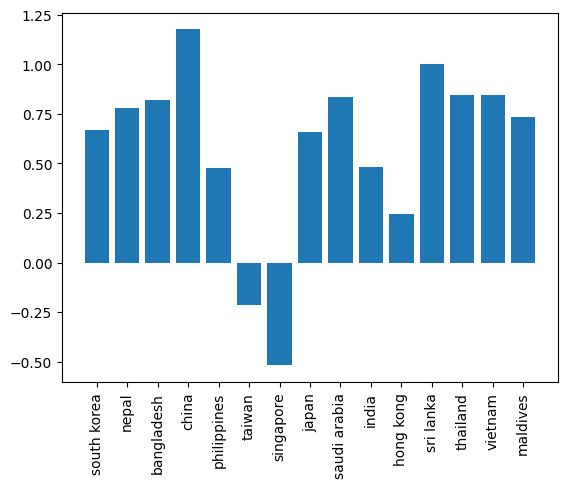

In [19]:
facts = [x[0] for x in estimates]
blcs = [x[1] for x in estimates]
plt.bar(facts, blcs)
plt.xticks(rotation=90)
plt.show()

# Functions for Ally

Here is a function that you can call anytime --- you just need to specify the subject number, the lesson ("Asian Flags" vs "Caribbean Flags") and your best estimate for that subject's SOF (ideally, your mean SOF for the "unknown" data. 

In [20]:
def decode_prior_knowledge(subject, lesson, sof):
    global DATA 
    global SOF
    SOF = sof
    DATA = data
    sdata = DATA[DATA.userId == subject]  # extract all data for that subject
    sldata = sdata[sdata.lessonId == lesson]  # extract all data for that lesson

    estimates = []
    #print(set(sldata.answer))
    for fact in set(sldata.answer):
        DATA = sldata[sldata.answer == fact]  # The DATA global var is accessed by the MLE loss function
        
#        # Get the corresponding prior_knowledge value from sldata
#        prior_knowledge = sldata[sldata.answer == fact]['prior_knowledge'].iloc[0]

        blc = minimize(loss, x0=[0],
                       method="Powell",
                       tol=0.0000001,
                       bounds=[(-10, 10)]).x
        
        estimates.append((fact, float(blc), subject, lesson))

    return pd.DataFrame(estimates, columns=("answer", "BLC", "userId", "lessonId"))

In [21]:
results = None

for user_id in set(data.userId):
    user_data = data[data['userId'] == user_id]  # Get all the data for that user
    
    for lesson_title in set(user_data['lessonId']):
        lesson_data = user_data[user_data['lessonId'] == lesson_title]
        partial = decode_prior_knowledge(user_id, lesson_title, get_unknown_sof(user_id, lesson_title, unknown_sof))
        
        if results is None:
            results = partial
        else:
            results = pd.concat([results, partial], ignore_index=True, axis=0)


/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/819474468.py:22: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  estimates.append((fact, float(blc), subject, lesson))
/var/folders/n2/r7k4fm7j4233_5bbbnjfj3700000gn/T/ipykernel_12435/1426252809.py:13: RuntimeWarning: invalid value encountered in scalar power
  p =  ((beta/alpha) * (t/alpha)**(beta -1)) / (1 + (t/alpha)**beta)**2


In [22]:
#results = decode_prior_knowledge(user_id, lesson_title, 0.3)
#results

print(results)

                  answer       BLC  userId         lessonId
0             martinique  0.187186   89344  Caribbean Flags
1                grenada  0.696194   89344  Caribbean Flags
2               st lucia  0.844777   89344  Caribbean Flags
3             montserrat  0.169712   89344  Caribbean Flags
4     st kitts and nevis  0.717760   89344  Caribbean Flags
...                  ...       ...     ...              ...
1997           hong kong  0.488451   89343      Asian Flags
1998             vietnam  0.498980   89343      Asian Flags
1999            thailand  1.228410   89343      Asian Flags
2000           sri lanka  1.865360   89343      Asian Flags
2001            maldives  1.637048   89343      Asian Flags

[2002 rows x 4 columns]


In [23]:
results.to_csv("results_MLE.csv")

In [24]:

plt.bar(results['Fact'], results['BLC'], color='lightblue')  # Set the color to blue
plt.xticks(results['Fact'], rotation='vertical')  # Rotates x-axis labels and uses custom order
plt.xlabel('Fact')
plt.ylabel('BLC')
plt.title('Bar Graph with Custom Ordered X-Axis Labels')
plt.tight_layout()
plt.show()

plt.bar(results['Fact'], results['BLC'], color='blue')  # Set the color to blue
plt.xticks(rotation='vertical')  # Rotates x-axis labels vertically
plt.xlabel('Fact')
plt.ylabel('BLC')
plt.title('Bar Graph with Vertical X-Axis Labels')

# Set y-axis limits from 0 to 1
plt.ylim(1, 2)

plt.tight_layout()
plt.show()

KeyError: 'Fact'